In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functools

%matplotlib inline

#plt.rcParams['figure.figsize'] = [10,5]

# Set columns to full width
#pd.set_option('display.max_columns', None)  

df = pd.read_csv(".\\EmailData.csv", encoding = "ISO-8859-1", dtype={'Subject': str} )
df['Subject'] = df['Subject'].astype(str) 
df = df.dropna(subset=['Body'])
df.sort_values(by=['Received'], inplace=True)
df.drop(columns=['Received', 'Received'], inplace=True)

df['Text'] = df['Subject'] + ' ' + df['Body']

class_values = df.Class.values
labels = class_values = class_values.reshape(-1,1)






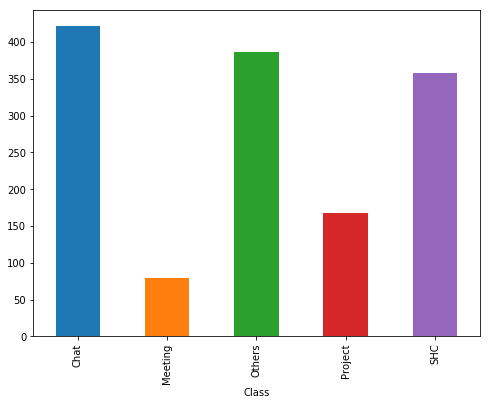

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Class').Sender.count().plot.bar(ylim=0)
plt.show()



In [13]:
# Text representation

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 3), 
                        stop_words='english')
features = tfidf.fit_transform(df.Text).toarray()
features.shape

(1428, 20168)

In [14]:
# find the terms that are the most correlated with each of labels 

from sklearn.feature_selection import chi2
import numpy as np
N = 2
test_labels = ["Project","Others", "Chat","SHC"]
for value in test_labels:
  features_chi2 = chi2(features, labels == value)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("#", value)    
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# Project
  . Most correlated unigrams:
. tangri
. australia
  . Most correlated bigrams:
. rohit tangri
. com quintiq
# Others
  . Most correlated unigrams:
. 3400
. jst
  . Most correlated bigrams:
. peoplesupport dsone
. dsone 3ds
# Chat
  . Most correlated unigrams:
. kenny
. pm
  . Most correlated bigrams:
. pm hi
. goh kenny
# SHC
  . Most correlated unigrams:
. x0a
. apos
  . Most correlated bigrams:
. apos x0a
. apos apos


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Class'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [17]:
print(clf.predict(count_vect.transform(["""
Hi All,

I understand the restrictions of the Bronze Hosting SLA and the need to update the .jks file. However if we are updating configuration in any way that could affect the customer, either in working hours or not we need to let them know of any potential downtime and get their buy in. 

Best Regards,

Michael

DS Australia Pty Ltd. | 15 William Street | 3000 Melbourne | Australia

"""])))


['Project']


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df.groupby('model_name').accuracy.mean()


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

model_name
LinearSVC                 0.966992
LogisticRegression        0.952270
MultinomialNB             0.958593
RandomForestClassifier    0.881557
Name: accuracy, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


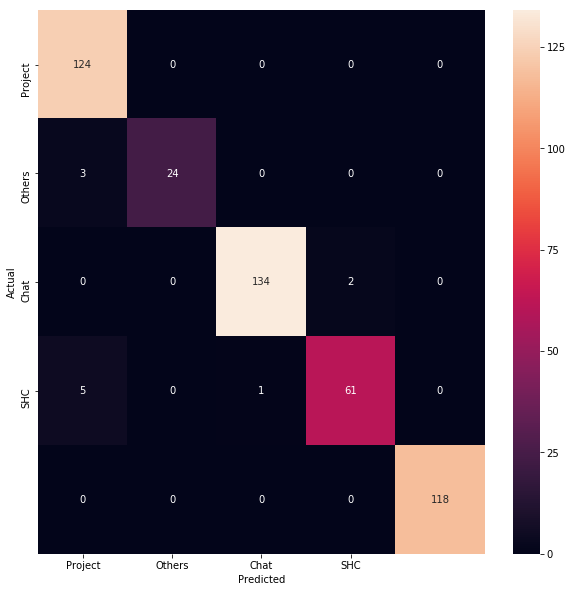

Accuracy: 0.9766949152542372


In [19]:
import seaborn as sns
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=test_labels, yticklabels=test_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
